Investigating admixture, divergence and diversity in windows.
Dataset generated in this notebook will be used for the SMBE poster.

In [1]:
%run ../scripts/notebook_settings.py
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

In [2]:
meta_data_samples = pd.read_table("../data/metadata_with_x_missing.txt", sep=" ")
chrom_number = "X"
zarr_dir = "/faststorage/project/baboondiversity/data/PG_baboons_mmul_20_04_2021/callset.zarr/chr{}"
chromosome_numbers = ['{}'.format(x) for x in range(1, 21)] + ['X']

Supporting functions to use

In [3]:
import bisect

def generate_input(a_name, b_name, c_name, d_name, chrom_number):
    zarr_dir = "/faststorage/project/baboondiversity/data/PG_baboons_mmul_20_04_2021/callset.zarr/chr{}"
    callset = zarr.open_group(zarr_dir.format(chrom_number), mode="r")
    gt = allel.GenotypeArray(callset["calldata/GT"])
    bi_sites = gt.count_alleles().is_biallelic()
    pos = callset["variants/POS"][:].compress(bi_sites)
    gt = gt.compress(bi_sites)
    a_ac = gt.take(meta_data_samples.loc[(meta_data_samples.C_origin == a_name) &
                                    (meta_data_samples.Sex == "F")].callset_index.values, axis=1).count_alleles(max_allele=1)
    b_ac = gt.take(meta_data_samples.loc[(meta_data_samples.C_origin == b_name) &
                                    (meta_data_samples.Sex == "F")].callset_index.values, axis=1).count_alleles(max_allele=1)
    c_ac = gt.take(meta_data_samples.loc[(meta_data_samples.C_origin == c_name) &
                                    (meta_data_samples.Sex == "F")].callset_index.values, axis=1).count_alleles(max_allele=1)
    d_ac = gt.take(meta_data_samples.loc[(meta_data_samples.C_origin == d_name)].callset_index.values, axis=1).count_alleles(max_allele=1)
    b_gt = gt.take(meta_data_samples.loc[(meta_data_samples.C_origin == b_name) &
                                    (meta_data_samples.Sex == "F")].callset_index.values, axis=1)
    return a_ac, b_ac, c_ac, d_ac, b_gt, pos

def f_hat_d(aca, acb, acc, acd):
    a = aca.to_frequencies()[:, 1]
    b = acb.to_frequencies()[:, 1]
    c = acc.to_frequencies()[:, 1]
    d = acd.to_frequencies()[:, 1]
    num = (a - b) * (c - d)
    max_bc = np.maximum(b, c)
    den = (a + max_bc - (2 * a * max_bc)) * (max_bc + d - (2 * max_bc * d))

    return num, den

def locate_range_empty_allowed(self, start=None, stop=None):
        if start is None:
            start_index = 0
        else:
            start_index = bisect.bisect_left(self, start)
        if stop is None:
            stop_index = len(self)
        else:
            stop_index = bisect.bisect_right(self, stop)

        loc = slice(start_index, stop_index)
        return loc

First part, independent of fst_chroms, I will now calculate diversity, PBS (using two nearest), and ABBA-BABA (two nearest and Gelada). Calculate it both for f_hat and pattersons D. While you are at it, you might as well also calculate fst between A and B.

In [4]:
def windowed_diversity_divergence_stats(origin_l_l, chrom_list, s):
    start_l, n_s_l, chrom_l, w_n, pop_l = [], [], [], [], [] #window information
    d_l, f_hat_l = [], [] #admixture statistics
    fst_l, pbs_l = [], [] #distance and selection statistics
    pi_l = [] #diversity estimate
    for chrom in chrom_list:
        print("Working on chr", chrom)
        zarr_dir = "/faststorage/project/baboondiversity/data/PG_baboons_mmul_20_04_2021/callset.zarr/chr{}"
        callset = zarr.open_group(zarr_dir.format(chrom), mode="r")
        gt = allel.GenotypeArray(callset["calldata/GT"])
        bi_sites = gt.count_alleles().is_biallelic()
        pos = callset["variants/POS"][:].compress(bi_sites)
        pos_sorted = allel.SortedIndex(pos)
        gt = gt.compress(bi_sites)
        d_ac = gt.take(meta_data_samples.loc[(meta_data_samples.C_origin == "Gelada, Captive")].callset_index.values, axis=1).count_alleles(max_allele=1)
        for origin_trio in origin_l_l:
            a, b, c = origin_trio[0], origin_trio[1], origin_trio[2]
            a_ac = gt.take(meta_data_samples.loc[(meta_data_samples.C_origin == a) &
                                    (meta_data_samples.Sex == "F")].callset_index.values, axis=1).count_alleles(max_allele=1)
            b_ac = gt.take(meta_data_samples.loc[(meta_data_samples.C_origin == b) &
                                    (meta_data_samples.Sex == "F")].callset_index.values, axis=1).count_alleles(max_allele=1)
            c_ac = gt.take(meta_data_samples.loc[(meta_data_samples.C_origin == c) &
                                    (meta_data_samples.Sex == "F")].callset_index.values, axis=1).count_alleles(max_allele=1)
            d_est = allel.patterson_d(a_ac, b_ac, c_ac, d_ac) #Calculating Pattersons D for all sites
            f_hat = f_hat_d(a_ac, b_ac, c_ac, d_ac) #Calculating f_hat for all sites
            fst1 = allel.hudson_fst(b_ac, c_ac)
            fst2 = allel.hudson_fst(b_ac, a_ac)
            fst3 = allel.hudson_fst(a_ac, c_ac)
            pi = allel.mean_pairwise_difference(b_ac)
            for i in range(0, pos[-1], s):
                pos_range = locate_range_empty_allowed(pos_sorted, i, i+s-1)
                pos_window = pos_sorted[pos_range]
                start_l.append(i), n_s_l.append(len(pos_window)), chrom_l.append("chr"+chrom)
                pop_l.append(origin_trio[1])
                if len(pos_window) > 9:
                    d_l.append(np.nansum(d_est[0][pos_range])/np.nansum(d_est[1][pos_range]))
                    f_hat_l.append(np.nansum(f_hat[0][pos_range])/np.nansum(f_hat[1][pos_range]))
                    fst_l.append(np.nansum(fst1[0][pos_range])/np.nansum(fst1[1][pos_range]))
                    t12 = -np.log(1-min(np.nansum(fst1[0][pos_range])/np.nansum(fst1[1][pos_range]), 0.99999))
                    t13 = -np.log(1-min(np.nansum(fst2[0][pos_range])/np.nansum(fst2[1][pos_range]), 0.99999))
                    t23 = -np.log(1-min(np.nansum(fst3[0][pos_range])/np.nansum(fst3[1][pos_range]), 0.99999))
                    ret = (t12 + t13 - t23) / 2
                    norm = 1 + (t12 + t13 + t23) / 2
                    pbs_l.append(ret/norm)
                    pi_l.append(np.nansum(pi[pos_range]))
                else:
                    d_l.append(np.nan)
                    f_hat_l.append(np.nan)
                    fst_l.append(np.nan)
                    pbs_l.append(np.nan)
                    pi_l.append(np.nan)
                w_n.append(i/s)
    df = pd.DataFrame(data={"start": w_n, "start_pos": start_l, "number of sites": n_s_l, "chrom": chrom_l,
                            "D": d_l, "f_hat": f_hat_l, "fst": fst_l, "PBS": pbs_l, "pi": pi_l, "pop": pop_l})
    return df

In [ ]:
window_size = 10000
#I do not use the papio trio, since P. papio is very diverged from everything else
origin_l_l = [['Anubis, Tanzania', 'Anubis, Ethiopia', 'Cynocephalus, Western Tanzania'],
              ['Anubis, Ethiopia', 'Anubis, Tanzania', 'Cynocephalus, Western Tanzania'],
              ['Anubis, Ethiopia', 'Hamadryas, Ethiopia', 'Cynocephalus, Western Tanzania'],
              ['Kindae, Zambia', 'Cynocephalus, Western Tanzania', 'Cynocephalus, Central Tanzania'],
              ['Cynocephalus, Western Tanzania', 'Kindae, Zambia',  'Cynocephalus, Central Tanzania'],
              ['Kindae, Zambia', 'Ursinus, Zambia', 'Cynocephalus, Western Tanzania'],
              ['Cynocephalus, Western Tanzania', 'Cynocephalus, Central Tanzania', 'Kindae, Zambia']]
df_trios = windowed_diversity_divergence_stats(origin_l_l, chromosome_numbers, window_size)
df_trios

Working on chr 1


/home/eriks/miniconda3/envs/baboondiversity/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars
/home/eriks/miniconda3/envs/baboondiversity/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in double_scalars
/home/eriks/miniconda3/envs/baboondiversity/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in double_scalars
/home/eriks/miniconda3/envs/baboondiversity/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in double_scalars
/home/eriks/miniconda3/envs/baboondiversity/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in double_scalars
/home/eriks/miniconda3/envs/baboondiversity/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in double_scalars


Working on chr 2
Working on chr 3
Working on chr 4


/home/eriks/miniconda3/envs/baboondiversity/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in double_scalars


Working on chr 5
Working on chr 6
Working on chr 7
Working on chr 8
Working on chr 9
Working on chr 10
Working on chr 11
Working on chr 12
Working on chr 13
Working on chr 14
Working on chr 15
Working on chr 16
Working on chr 17
Working on chr 18
Working on chr 19


origin_l_l = [['Anubis, Tanzania', 'Anubis, Ethiopia', 'Hamadryas, Ethiopia'],
              ['Anubis, Ethiopia', 'Anubis, Tanzania', 'Hamadryas, Ethiopia'],
              ['Anubis, Ethiopia', 'Hamadryas, Ethiopia', 'Anubis, Tanzania'],
              ['Kindae, Zambia', 'Cynocephalus, Western Tanzania', 'Cynocephalus, Central Tanzania'],
              ['Cynocephalus, Western Tanzania', 'Kindae, Zambia',  'Cynocephalus, Central Tanzania'],
              ['Kindae, Zambia', 'Ursinus, Zambia', 'Cynocephalus, Western Tanzania'],
              ['Cynocephalus, Western Tanzania', 'Cynocephalus, Central Tanzania', 'Kindae, Zambia']]

In [ ]:
df_trios.to_csv("../steps/trio_df_10kb_chroms_mmul10_new_trios.txt", index=False, sep=" ")
#df_trios = pd.read_csv("../steps/trio_df_10kb_chroms_mmul10.txt", sep=" ")

<AxesSubplot:xlabel='number of sites', ylabel='Count'>

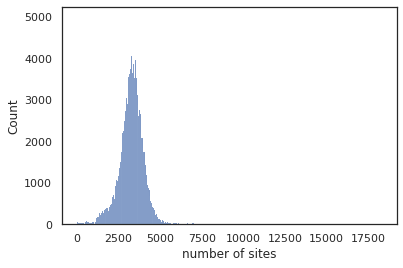

In [7]:
sns.histplot(data=df_trios, x="number of sites")

In [7]:
len(df_trios.loc[df_trios["number of sites"] == 0])/len(df_trios)
df_trios_p = df_trios.loc[(df_trios["number of sites"] > 2000) & (df_trios["number of sites"] < 5000)]
df_trios_p.loc[df_trios_p["chrom"] == "chrX", "chrtype"] = "chrX"
df_trios_p.loc[df_trios_p["chrom"] != "chrX", "chrtype"] = "autosome"

/home/eriks/miniconda3/envs/baboondiversity/lib/python3.7/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/eriks/miniconda3/envs/baboondiversity/lib/python3.7/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


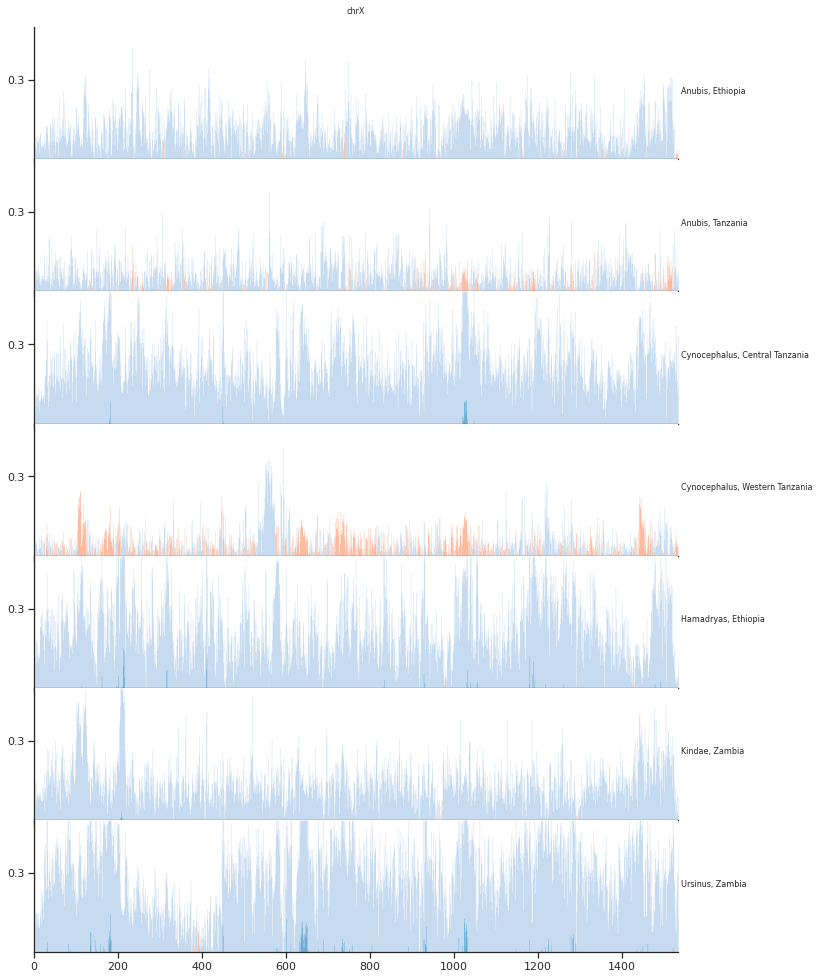

In [8]:
fig = horizonplot(df_trios.loc[df_trios.chrom=="chrX"], 'PBS', width=1, col='chrom', row='pop', aspect=5, size=2, cut=0.5)

In [13]:
df_trios_x = df_trios.loc[df_trios.chrom=="chrX"]
mean_pi = df_trios_x.pi.mean()
df_trios_x["PBS_pi"] = df_trios_x.PBS*mean_pi/df_trios_x.pi

/home/eriks/miniconda3/envs/baboondiversity/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


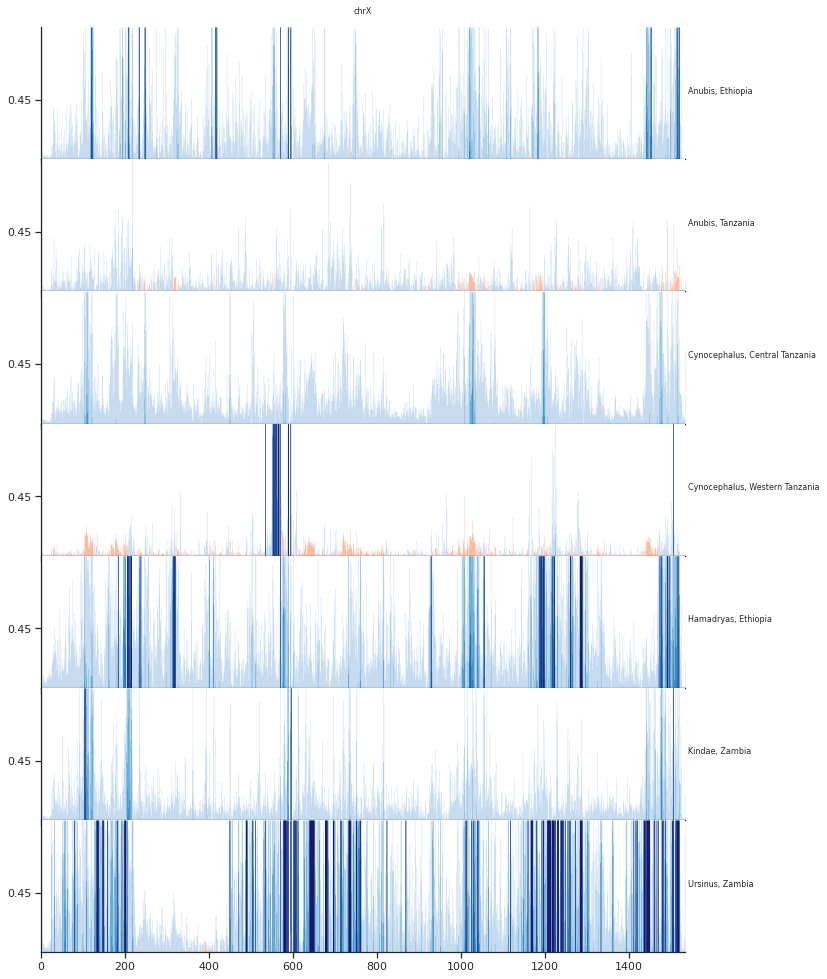

In [16]:
fig = horizonplot(df_trios_x, 'PBS_pi', width=1, col='chrom', row='pop', aspect=5, size=2, cut=1)

/home/eriks/miniconda3/envs/baboondiversity/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


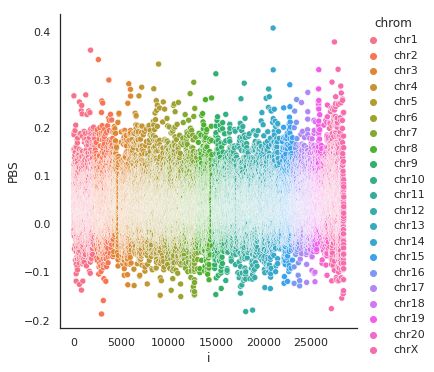

In [17]:
single_species = df_trios.loc[df_trios["pop"] == "Anubis, Tanzania"]
single_species.reset_index(inplace=True, drop=True); single_species['i'] = single_species.index
sns.relplot(data=single_species, x="i", y="PBS", hue="chrom")

<AxesSubplot:xlabel='PBS', ylabel='Density'>

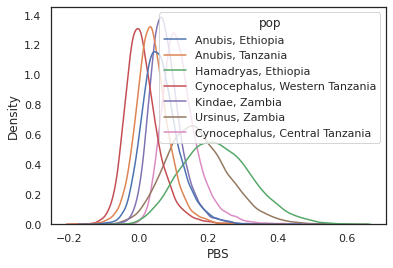

In [11]:
sns.kdeplot(data=df_trios_p, x="PBS", hue="pop")

<AxesSubplot:xlabel='pi', ylabel='Density'>

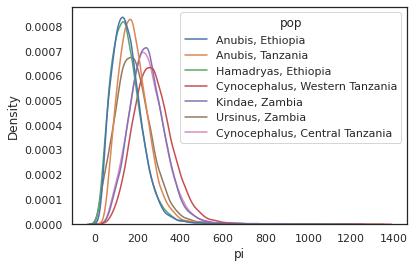

In [12]:
sns.kdeplot(data=df_trios_p, x="pi", hue="pop")

<AxesSubplot:xlabel='pi', ylabel='PBS'>

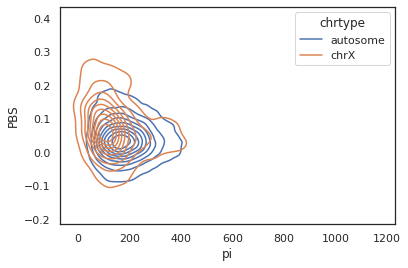

In [26]:
sns.kdeplot(data=df_trios_p.loc[df_trios_p["pop"] == 'Anubis, Tanzania'],
            x="pi", y="PBS", hue="chrtype", common_norm=False)

In [18]:
df_trios.loc[df_trios.chrom=="chrX"].PBS.mean(), df_trios.loc[df_trios.chrom!="chrX"].PBS.mean()

(0.15452893121827901, 0.10034388753491978)

In [9]:
df_trios_p.chrom.isin(["chr7", "chrX"])

0         False
1         False
2         False
3         False
4         False
          ...  
199011     True
199012     True
199013     True
199014     True
199015     True
Name: chrom, Length: 181839, dtype: bool

<AxesSubplot:xlabel='pi', ylabel='PBS'>

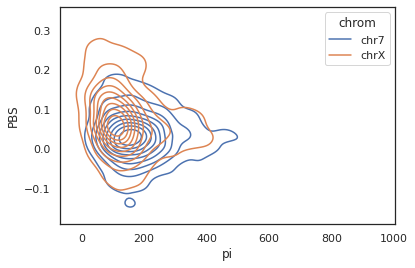

In [11]:
sns.kdeplot(data=df_trios_p.loc[(df_trios_p["pop"] == 'Anubis, Tanzania') & (df_trios_p.chrom.isin(["chr7", "chrX"]))],
            x="pi", y="PBS", hue="chrom", common_norm=False)

<AxesSubplot:xlabel='chrtype', ylabel='PBS'>

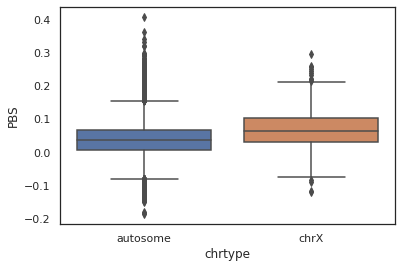

In [21]:
sns.boxplot(data=df_trios_p.loc[df_trios_p["pop"] == 'Anubis, Tanzania'],
           y="PBS", x="chrtype")

<AxesSubplot:xlabel='start_pos', ylabel='PBS'>

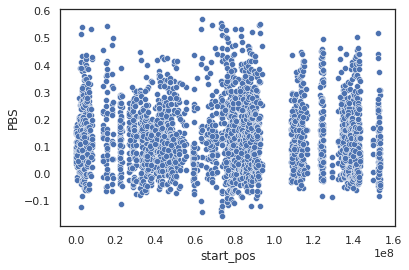

In [47]:
sns.scatterplot(data=df_trios_p.loc[df_trios_p.chrom=="chrX"], x="start_pos", y="PBS")

In [48]:
df_trios_p.groupby(["chrom"]).mean()

,start,start_pos,number of sites,D,f_hat,fst,PBS,pi
chrom,,,,,,,,
chr1,1119.049180,1.119049e+08,3218.964481,0.077395,0.056182,0.264797,0.102406,193.771574
chr10,513.629630,5.136296e+07,3418.948802,0.081626,0.057965,0.261489,0.099554,214.428429
chr11,689.990115,6.899901e+07,3271.901153,0.076469,0.055303,0.268990,0.105217,197.372244
chr12,656.377953,6.563780e+07,3289.679528,0.087096,0.062224,0.274334,0.103645,203.015881
chr13,551.287214,5.512872e+07,3358.350191,0.086266,0.061361,0.266245,0.101722,209.578060
chr14,641.044935,6.410449e+07,3266.640523,0.076564,0.055974,0.266037,0.102322,199.579528
chr15,589.979343,5.899793e+07,3296.466667,0.083112,0.059660,0.283110,0.109436,195.062314
chr16,407.278755,4.072788e+07,3362.209743,0.085768,0.061501,0.271389,0.102837,211.603401
chr17,480.591703,4.805917e+07,3604.522926,0.078157,0.058873,0.253205,0.098758,227.068221


<AxesSubplot:xlabel='fst', ylabel='Count'>

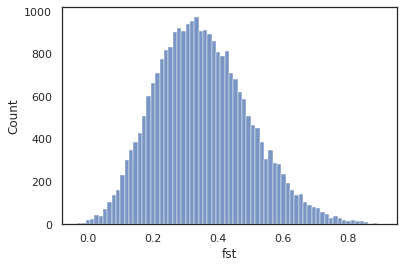

In [41]:
sns.histplot(data=df_trios_p, x="fst")

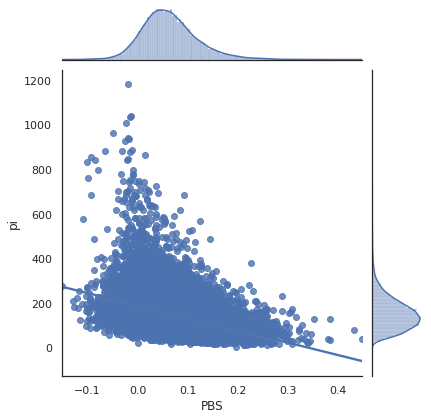

In [56]:
sns.jointplot(data=df_trios_p, x="PBS", y="pi", kind="reg")

<AxesSubplot:xlabel='PBS', ylabel='Probability'>

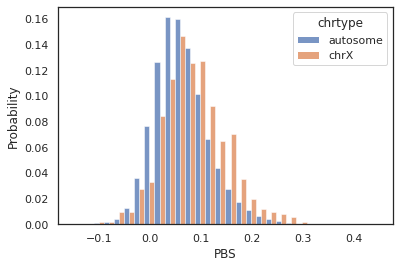

In [73]:
sns.histplot(data=df_trios_p, x="PBS", hue="chrtype", common_norm=False,stat="probability", multiple="dodge", bins=30)

Site-based implementation

In [ ]:
def windowed_diversity_divergence_stats(origin_l_l, chrom_list, s):
    start_l, end_l, chrom_l, w_n, pop_l = [], [], [], [], [] #window information
    d_l, f_hat_l = [], [] #admixture statistics
    fst_l, pbs_l = [], [] #distance and selection statistics
    pi_l = [] #diversity estimate
    for chrom in chrom_list:
        print("Working on chr", chrom)
        zarr_dir = "/faststorage/project/baboondiversity/data/PG_baboons_mmul_20_04_2021/callset.zarr/chr{}"
        callset = zarr.open_group(zarr_dir.format(chrom), mode="r")
        gt = allel.GenotypeArray(callset["calldata/GT"])
        bi_sites = gt.count_alleles().is_biallelic()
        pos = callset["variants/POS"][:].compress(bi_sites)
        pos_sorted = allel.SortedIndex(pos)
        gt = gt.compress(bi_sites)
        d_ac = gt.take(meta_data_samples.loc[(meta_data_samples.C_origin == "Gelada, Captive")].callset_index.values, axis=1).count_alleles(max_allele=1)
        for origin_trio in origin_l_l:
            a, b, c = origin_trio[0], origin_trio[1], origin_trio[2]
            a_ac = gt.take(meta_data_samples.loc[(meta_data_samples.C_origin == a) &
                                    (meta_data_samples.Sex == "F")].callset_index.values, axis=1).count_alleles(max_allele=1)
            b_ac = gt.take(meta_data_samples.loc[(meta_data_samples.C_origin == b) &
                                    (meta_data_samples.Sex == "F")].callset_index.values, axis=1).count_alleles(max_allele=1)
            c_ac = gt.take(meta_data_samples.loc[(meta_data_samples.C_origin == c) &
                                    (meta_data_samples.Sex == "F")].callset_index.values, axis=1).count_alleles(max_allele=1)
            d_est = allel.patterson_d(a_ac, b_ac, c_ac, d_ac) #Calculating Pattersons D for all sites
            f_hat = f_hat_d(a_ac, b_ac, c_ac, d_ac) #Calculating f_hat for all sites
            
            pi = allel.mean_pairwise_difference(b_ac)
            
    df = pd.DataFrame(data={"start": w_n, "start_pos": start_l, "number of sites": n_s_l, "chrom": chrom_l,
                            "D": d_l, "f_hat": f_hat_l, "fst": fst_l, "PBS": pbs_l, "pi": pi_l, "pop": pop_l})
    return df

Calculate fst for all combinations of C_origins

In [9]:
origin_list = ['Cynocephalus, Central Tanzania', 'Kindae, Zambia', 'Hamadryas, Ethiopia',
               'Anubis, Tanzania', 'Cynocephalus, Western Tanzania', 'Papio, Senegal',
               'Ursinus, Zambia', 'Anubis, Ethiopia']
def fst_chroms(origin_list):
    a_id = []
    b_id = []
    fst_l = []
    chrom_l = []
    chrom_length = []
    for chrom in chromosome_numbers:
        callset = zarr.open_group(zarr_dir.format(chrom), mode="r")
        gt = allel.GenotypeArray(callset["calldata/GT"])
        bi_sites = gt.count_alleles().is_biallelic()
        pos = callset["variants/POS"][:].compress(bi_sites)
        gt = gt.compress(bi_sites)
        for i in range(len(origin_list)):
            for j in range(i):
                a_ac = gt.take(meta_data_samples.loc[(meta_data_samples.C_origin == origin_list[i]) &
                                        (meta_data_samples.Sex == "F")].callset_index.values, axis=1).count_alleles(max_allele=1)
                b_ac = gt.take(meta_data_samples.loc[(meta_data_samples.C_origin == origin_list[j]) &
                                        (meta_data_samples.Sex == "F")].callset_index.values, axis=1).count_alleles(max_allele=1)
                num, den = allel.hudson_fst(a_ac, b_ac)
                a_id.append(origin_list[i]), b_id.append(origin_list[j])
                fst_l.append(np.nansum(num)/np.nansum(den))
                chrom_l.append(chrom), chrom_length.append(pos[-1])
        print(chrom)
    
    df = pd.DataFrame(data={"Origin_a": a_id, "Origin_b": b_id, "fst": fst_l,
                            "chrom": chrom_l, "chrom_length": chrom_length})
    return df
#df_fst = fst_chroms(origin_list)

In [3]:
#df_fst.to_csv("../steps/fst_chroms_mmul10.txt", index=False, sep=" ")
df_fst = pd.read_csv("../steps/fst_chroms_mmul10.txt", sep=" ")
df_fst.loc[df_fst["chrom"] == "X", "chrtype"] = "chrX"
df_fst.loc[df_fst["chrom"] != "X", "chrtype"] = "autosomes"

In [4]:
df_g = df_fst.groupby(["chrom"]).mean()

In [5]:
df_g.iloc[20:, ]

,fst,chrom_length
chrom,,
X,0.506857,153368156


<AxesSubplot:xlabel='fst', ylabel='Count'>

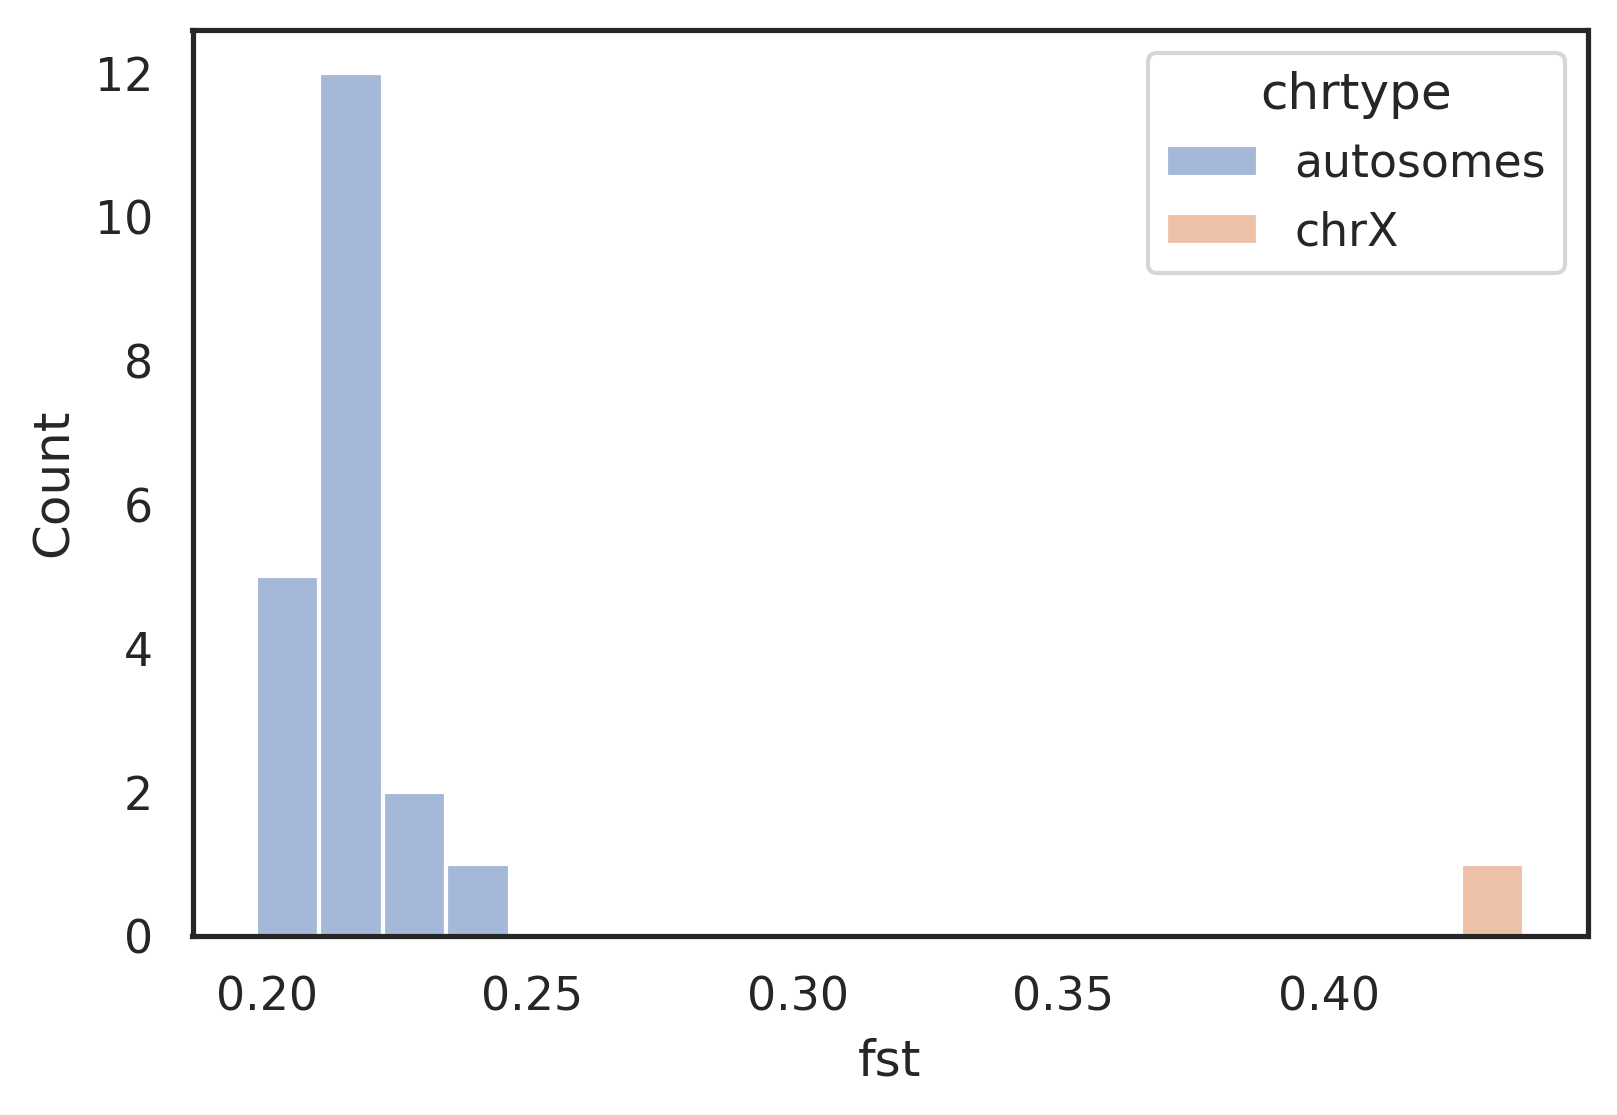

In [16]:
sns.histplot(data=df_fst.loc[df_fst.Origin_a == "Kindae, Zambia"], x="fst", hue="chrtype", bins=20)

Merge autosomal fsts

In [8]:
origin_list = ['Cynocephalus, Central Tanzania', 'Kindae, Zambia', 'Hamadryas, Ethiopia',
               'Anubis, Tanzania', 'Cynocephalus, Western Tanzania', 'Papio, Senegal',
               'Ursinus, Zambia', 'Anubis, Ethiopia']
a_l = []
b_l = []
autosomal_fst = []
x_fst = []
for i in range(len(origin_list)):
    for j in range(i):
        sub_df = df_fst.loc[(df_fst.chrom != "X") & (df_fst.Origin_a == origin_list[i]) & (df_fst.Origin_b == origin_list[j])]
        autosomal_fst.append((sub_df.fst*sub_df.chrom_length).sum()/(sub_df.chrom_length.sum()))
        x_fst.append(df_fst.loc[(df_fst.chrom == "X") &
                            (df_fst.Origin_a == origin_list[i]) & (df_fst.Origin_b == origin_list[j])].fst.sum())
        a_l.append(origin_list[i])
        b_l.append(origin_list[j])
fst_summary_df = pd.DataFrame(data={"Origin_a": a_l,"Origin_b": b_l,
                                    "Autosomal Fst": autosomal_fst, "chrX Fst": x_fst})

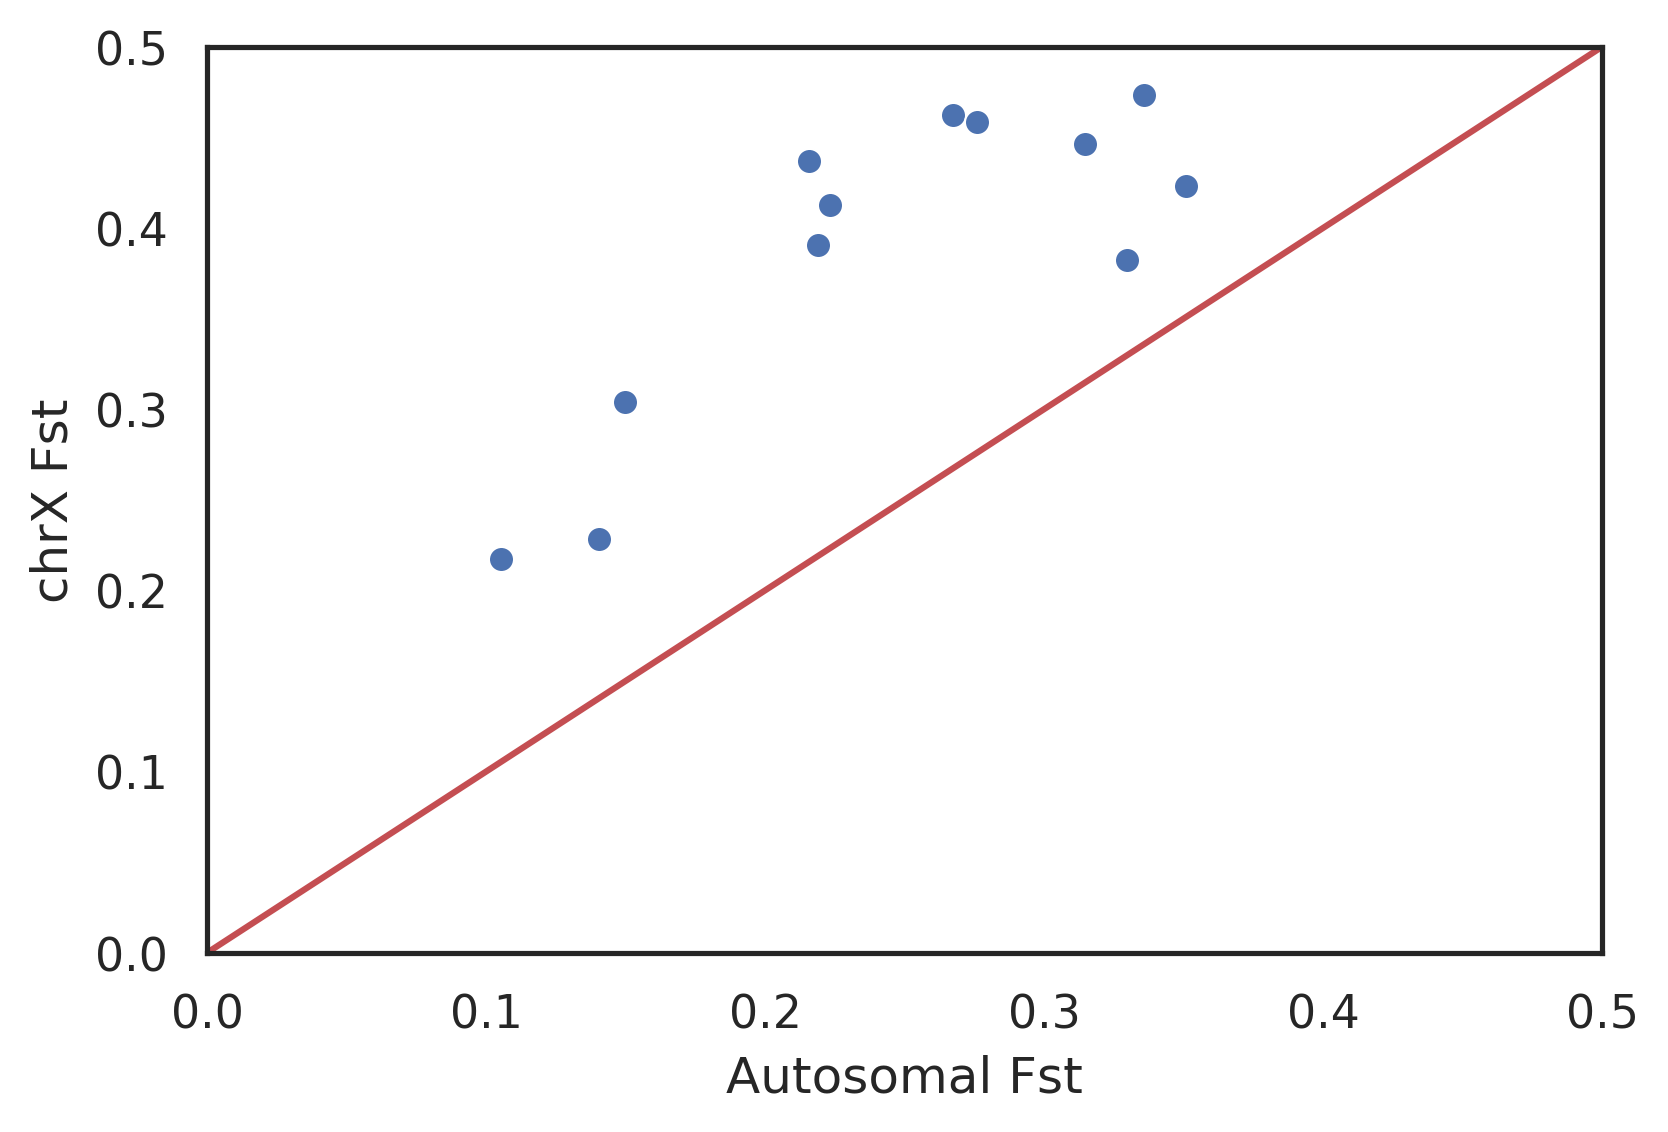

In [9]:
g = sns.scatterplot(data=fst_summary_df.loc[(fst_summary_df.Origin_a != "Papio, Senegal") &
                                            (fst_summary_df.Origin_b != "Papio, Senegal")], x="Autosomal Fst", y="chrX Fst")
g.set(ylim=(0,0.5), xlim=(0,0.5))
X_plot = np.linspace(0, 1)
Y_plot = 1*X_plot
plt.plot(X_plot, Y_plot, color='r')

In [17]:
fst_summary_df

,Origin_a,Origin_b,Autosomal Fst,chrX Fst
0,"Kindae, Zambia","Cynocephalus, Central Tanzania",0.215561,0.436831
1,"Hamadryas, Ethiopia","Cynocephalus, Central Tanzania",0.400346,0.519722
2,"Hamadryas, Ethiopia","Kindae, Zambia",0.394623,0.564265
3,"Anubis, Tanzania","Cynocephalus, Central Tanzania",0.335739,0.473295
4,"Anubis, Tanzania","Kindae, Zambia",0.340980,0.531277
5,"Anubis, Tanzania","Hamadryas, Ethiopia",0.329697,0.382076
6,"Cynocephalus, Western Tanzania","Cynocephalus, Central Tanzania",0.149773,0.303876
7,"Cynocephalus, Western Tanzania","Kindae, Zambia",0.105402,0.217316
8,"Cynocephalus, Western Tanzania","Hamadryas, Ethiopia",0.314799,0.446067
9,"Cynocephalus, Western Tanzania","Anubis, Tanzania",0.219049,0.390823


In [16]:
fst_summary_df["X autosome ratio"] = fst_summary_df["chrX Fst"]/fst_summary_df["Autosomal Fst"]

In [20]:
fst_summary_df.loc[(fst_summary_df.Origin_a != "Papio, Senegal") &
                                            (fst_summary_df.Origin_b != "Papio, Senegal")].sort_values(["Autosomal Fst"])

,Origin_a,Origin_b,Autosomal Fst,chrX Fst,X autosome ratio
7,"Cynocephalus, Western Tanzania","Kindae, Zambia",0.105402,0.217316,2.061786
24,"Anubis, Ethiopia","Anubis, Tanzania",0.140601,0.228236,1.623291
6,"Cynocephalus, Western Tanzania","Cynocephalus, Central Tanzania",0.149773,0.303876,2.028919
0,"Kindae, Zambia","Cynocephalus, Central Tanzania",0.215561,0.436831,2.026480
9,"Cynocephalus, Western Tanzania","Anubis, Tanzania",0.219049,0.390823,1.784180
19,"Ursinus, Zambia","Cynocephalus, Western Tanzania",0.223355,0.412454,1.846630
16,"Ursinus, Zambia","Kindae, Zambia",0.261570,0.530002,2.026232
15,"Ursinus, Zambia","Cynocephalus, Central Tanzania",0.267273,0.462092,1.728916
25,"Anubis, Ethiopia","Cynocephalus, Western Tanzania",0.275976,0.458207,1.660311
8,"Cynocephalus, Western Tanzania","Hamadryas, Ethiopia",0.314799,0.446067,1.416988
